### エグゼクティブサマリー

**【分析の背景】**
サイト全体の平均LCP改善という表面的な指標に隠れた、決済ページ等の重要ページにおけるパフォーマンス改悪がビジネスに与える損失リスクを評価しました。本分析では、PyMC v5を用いた階層ベイズモデルに加え、ビジネス前提（売上感度）の不確実性を加味した「感度分析」を実行し、意思決定の妥当性を検証しています。

**【主要な発見】**
* **期待純利益**: Top/Detailページの改善効果により、全体では約 **8,210万円** の大幅な増収が期待値として算出されました。
* **収益化確率（勝率）**: しかし、全体の収益がプラスになる確率は **65.1%** に留まり、**約3回に1回は赤字になる** という不安定な状態です。
* **潜在的リスクの特定**: 最大の懸念点は「決済ページ（Checkout）」です。このページ単体では **77.4% の確率で1万円以上の損失が発生** しており、Topページの稼いだ利益を食いつぶす明確な「出血点」となっています。

**【最終アクション】**
**「条件付きリリース」** を推奨します。全体を一括リリースすることは、Checkoutページのリスク（勝率65%）が高すぎるため却下とします。
リスクの低い **Top/Detail ページの改善のみを部分的にリリース** し、Checkout ページに関しては実装をロールバックまたは修正した後、再検証を行うべきです。

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

/home/peta/petaLab/bayesian-iroha/.venv/lib/python3.11/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


In [2]:
# カラー定義
COLOR_PURPLE = "#9B5DE5"  # 事後分布・HDI
COLOR_YELLOW = "#F9C74F"  # ROPE領域
COLOR_GREEN  = "#06D6A0"  # 改善判定
COLOR_RED    = "#EF476F"  # 悪化判定
COLOR_GRAY   = "#8D99AE"  # 等価判定

# 1. Matplotlibのデフォルトカラーサイクルを変更
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=[COLOR_PURPLE, COLOR_YELLOW, COLOR_GREEN, COLOR_RED, COLOR_GRAY])

# 2. Seabornのスタイル設定
sns.set_style("whitegrid")
sns.set_palette([COLOR_PURPLE, COLOR_YELLOW, COLOR_GREEN, COLOR_RED, COLOR_GRAY])

In [3]:
print(f"PyMC version: {pm.__version__}")

# 再現性の確保
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

PyMC version: 5.26.1


In [4]:
# --- 1. Data の生成 (N=20 小規模Data) ---
def generate_weighted_scenario_data(n_per_page=20):
    """
    Top Page 改善、Checkout page 悪化の Trap-data 生成
    """
    pages = ["Top", "Detail", "Contract", "Checkout"]

    scenario = {
        'Top': (3000, 2500),  # 改善（良）
        'Detail': (2800, 2600),  # （微良）
        'Contract': (3500, 3550),  # 変化なし(微増)
        'Checkout': (3000, 4000)  #  悪化　★ここが罠
    }

    data = []
    for page in pages:
        mu_pre, mu_post = scenario[page]

        # Pre (対数正規分布)
        lcp_pre = rng.lognormal(mean=np.log(mu_pre), sigma=0.4, size=n_per_page)
        data.extend([{"page": page, "group": "pre", "lcp": val} for val in lcp_pre])

        # Post (対数正規分布)
        lcp_post = rng.lognormal(mean=np.log(mu_post), sigma=0.4, size=n_per_page)
        data.extend([{"page": page, "group": "post", "lcp": val} for val in lcp_post])

    return pd.DataFrame(data)

In [5]:
df = generate_weighted_scenario_data(n_per_page=20)

In [6]:
# 基本統計量の確認
print("--- 基本統計量（Group × Page） ---")

df.groupby("group").agg({"lcp": "mean"})

--- 基本統計量（Group × Page） ---


,lcp
group,
post,3196.734803
pre,3225.695790


単純に `df.groupby("group").agg({"lcp": "mean"})` を見ると、Sample数が均等なため
- Pre: 3225ms -> Post: 3196ms

と、全体として大きな変化はありません。

In [7]:
df.groupby(["page", "group"]).agg({"lcp": "mean"}).unstack()  # 確認

# unstack() は、MultiIndex（重層的なインデックス）を持つ Series や DataFrame のインデックスの最下層を、カラム（列）へと展開（ピボット）する効果があります。
# このコードの場合、groupby(["page", "group"]) によってインデックスが page と group の二段構えになりますが、
# .unstack() を付けることで、group（pre/Post）が横に並び、ページごとの比較がしやすくなります。

lcp             
group            post          pre
page                              
Checkout  3840.892359  3570.660555
Contract  3587.029423  3158.051664
Detail    2607.372864  3050.224780
Top       2751.644568  3123.846159

`Checkout` を見ると明確に悪化しています。

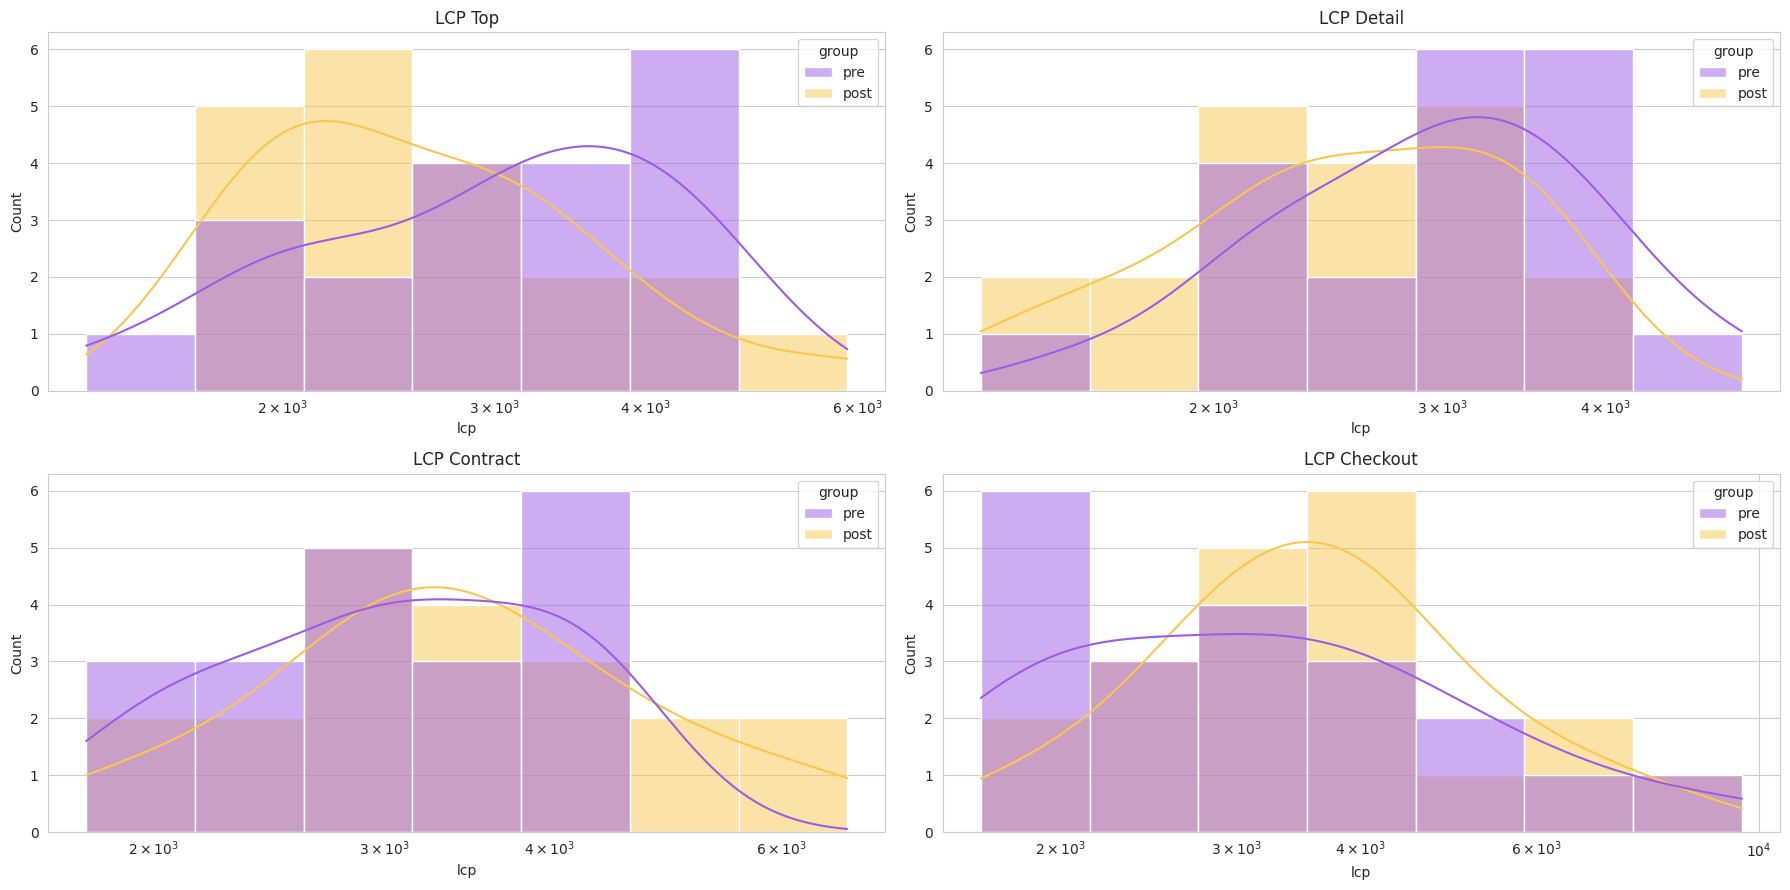

In [8]:
# 分布の可視化
fig, axes = plt.subplots(2, 2, figsize=(18, 9))
ax_flat = axes.flatten()

for i, page in enumerate(df["page"].unique()):
    sns.histplot(data=df[df["page"] == page], x="lcp", hue="group", kde=True, log_scale=True, ax=ax_flat[i])
    ax_flat[i].set_title(f"LCP {page}")

plt.tight_layout()
plt.show()

この可視化において注目すべき点は、「平均値の罠」が視覚的に表現されていることです。

1. TopページとDetailページ（改善傾向）:
    青色（Pre）に比べて、オレンジ色（Post）の分布が左側（LCPが小さい、つまり高速な方向）にシフトしていることが見て取れます。特にTopページでは、ヒストグラムの山が明確に左へ移動しており、パフォーマンス改善の恩恵を最も受けていることがわかります。
2. Contractページ（変化なし）:
    PreとPostの分布がほぼ重なっており、施策による影響がほとんど見られません。
3. Checkoutページ（改悪傾向：重要）:
    ここが本分析の「罠」となる部分です。他のページとは逆に、オレンジ色（Post）の分布が右側（LCPが大きい、つまり低速な方向）へシフトし、裾野も広がっています。これは、決済画面において明確なパフォーマンス低下が発生していることを示唆しています。


> ##### 技術的補足と直感的な説明
>1. 対数正規分布と対数スケール (Log Scale)
【定義】: LCPのような待ち時間データは、下限が0で右側に長い裾を持つ性質があるため、通常は対数正規分布に従います。このプロットでは log_scale=True を使用することで、歪んだデータを正規分布に近い形に変換し、中心傾向（最頻値や中央値）のズレを視覚的に比較しやすくしています。
【直感】: 待ち時間のデータは、「すごく遅い人」が一部混じるため、単純な平均をとると実態を見誤ります。このグラフでは、データの「偏り」を調整して、PreとPostの「山の位置」がどれくらいズレたかを、人間の目で直感的に捉えやすい形に整えています。
2. カーネル密度推定 (KDE: Kernel Density Estimation)
【定義】: ヒストグラムに重なっている曲線はカーネル密度推定です。これは、離散的なデータポイントから連続的な確率密度関数を推定する手法であり、ヒストグラムのビン（棒）の切り方に依存せずに、データの分布形状を滑らかに表現します。
【直感】: 点々としたデータの集まりを、「なだらかな山」として描いたものです。山の形を見ることで、「だいたい何秒くらいのユーザーが一番多いのか」や「分布のばらつき（山の幅）」を一目で比較できるようになります。


#### 結論としての意思決定支援
このプロットから得られるビジネス上の洞察は、**「全ページ合計の平均値では改善しているように見えても、最も売上に直結する Checkout ページで致命的な遅延が発生している」**というリスクの可視化です。

#### 非中心化による階層ベイズモデル
N=20のような小規模データで階層モデル（特に分散パラメータ $\sigma$ が小さい場合）を推定すると、MCMCサンプラーが「漏斗（Funnel）のような形状」の確率分布を探索できず、Divergences（発散） というエラーが頻発することがあります。
これはベイズ推論の信頼性を損ってしまう為、回避する為に、変数の依存関係を数式上で切り離す **「非中心化」** テクニックを用います。
- 中心化（Centered）: $\beta \sim \text{Normal}(\mu, \sigma)$
    - $\beta$ の値が決まる際、$\mu$ と $\sigma$ に直接依存する。
- 非中心化（Non-centered）: $z \sim \text{Normal}(0, 1)$, $\beta = \mu + z \cdot \sigma$
    - $z$ は標準正規分布から独立に生成され、あとでスケーリングされる。これによりサンプラーがスムーズに空間を移動できる。

In [9]:
idx_page, pages = pd.factorize(df["page"])
idx_group, groups = pd.factorize(df["group"])

# PyMC用 Coords (座標) 定義
coords = {
    "id_obs": df.index.values,
    "page": pages,
    "group": groups  # ["Pre", "Post"]"
}

複雑な階層モデルの可読性をあげる為、PyMC における
- カテゴリ変数のIndex化
    - 【定義】: モデル内部での行列演算を効率化するため、文字列（"Top", "Checkout"等）を整数インデックス（0, 1, ...）に変換する処理です。これにより、各観測データがどのグループ（階層）に属するかを、数式内でポインタのように参照できるようになります。
    - 【直感】: 「住所録」に名前でアクセスするのではなく、「出席番号」を割り振る作業です。「出席番号1番のLCPはこれ」と番号で管理することで、計算機が迷わず高速にデータを処理できるようになります。
- Coords(座標)の定義
    - 【定義】: 確率変数の各次元（Dimension）に対して、人間が理解できるラベルを付与する仕組みです。PyMC（内部的にはxarrayを使用）において、多次元配列の各軸が何を意味しているのか（どのページか、どのグループか）を明示的に宣言します。
    - 【直感】: グラフの「軸（ラベル）」を定義することです。ただの「4行2列の数字の塊」に、「縦軸はページ名（Top等）」「横軸は施策の前後（Pre/Post）」という名前を付けることで、後で結果を見たときに「どの数字がCheckoutページのPostの結果か」を一目でわかるようにします。

というプロセスを実施します。

##### なぜこれらが必要なのか？（主な3つの目的）
1. 高次元データの整合性確保 (Error Prevention)
    階層モデルでは、「ページ(4) × グループ(2)」のようにパラメータが多次元になります。
    Coordsを定義しておくと、PyMCが自動的に「4×2の行列」と「観測データ（N=160）」を正しくマッピングしてくれます。これにより、行列のサイズが合わないといった実行時エラーを未然に防ぐことができます。
2. 意味のある事後分布の解析 (Labeling)
    MCMCによるサンプリング結果（事後分布）を解析する際、Coordsが定義されていると、ArviZなどのツールを使って以下のように直感的にアクセスできます。
    trace.posterior["mu_cell"].sel(page="Checkout", group="Post") もしCoordsがないと、trace.posterior["mu_cell"][:, :, 3, 1] のように「マジックナンバー（3や1が何を指すか不明な状態）」で指定しなければならず、ミスや混乱の元になります。
3.  非中心化実装の柔軟性
    今回のモデルで採用している「非中心化（Non-centered）」モデルでは、標準正規分布からサンプリングした値にズレ（\sigma）を掛け合わせる操作を行います。
    Coordsがあると、この「ズレ」をどの次元に対して適用するのかを dims=("page", "group") のように名前で指定でき、モデルの構造が非常に読みやすくなります。

このように、Index化とCoordsの定義は、 **「計算機のための効率化」と「人間のための可読性・解析性」** を両立させるための非常に重要なベストプラクティスです。これを行うことで、将来的にページ数が増えたり、新しいセグメント（デバイス別など）を追加したりする場合も、モデルの拡張が容易になります

In [10]:
with pm.Model(coords=coords) as model:
    # --- Data Containers ---
    _idx_page  = pm.Data("idx_page", idx_page, dims="id_obs")
    _idx_group = pm.Data("idx_group", idx_group, dims="id_obs")
    _obs_lcp   = pm.Data("obs_lcp", df["lcp"].values, dims=("id_obs"))

    # --- Hierarchical Priors (Non-centered Parameterization)

    # 1. Global Intercept (全体の基準値)
    mu_global = pm.Normal("mu_global", mu=7.5, sigma=1.0, dims="group")

    # 2. Page-level Deviations (Page ごとのクせ)
    # sigma_page: ページ間のばらつきの大きさ
    sigma_page = pm.HalfNormal("sigma_page", sigma=0.5)

    # offset_page_z: 標準正規分布に従う「ズレの素」（非中心化の肝）
    # shape=(4page, 2group) -> 各ページ・各グループごとに固有の偏差を持つ
    offset_page_z = pm.Normal("offset_page_z", mu=0.0, sigma=1.0, dims=("page", "group"))

    # Deterministic で実際に偏差に変換: beta = mu + z * sigma
    mu_page = pm.Deterministic(
        "mu_page",
        mu_global + offset_page_z * sigma_page,  # broadcasting
        dims=("page", "group")
    )

    # --- Likelihood ---
    sigma_obs = pm.HalfNormal("sigma_obs", sigma=0.5)

    # 予測値の構築
    # mu_page は (page, group) の２次元配列なので、Index で参照
    mu_LCP = mu_page[_idx_page, _idx_group]

    lcp = pm.Lognormal("lcp", mu=mu_LCP, sigma=sigma_obs, observed=_obs_lcp, dims=("id_obs"))

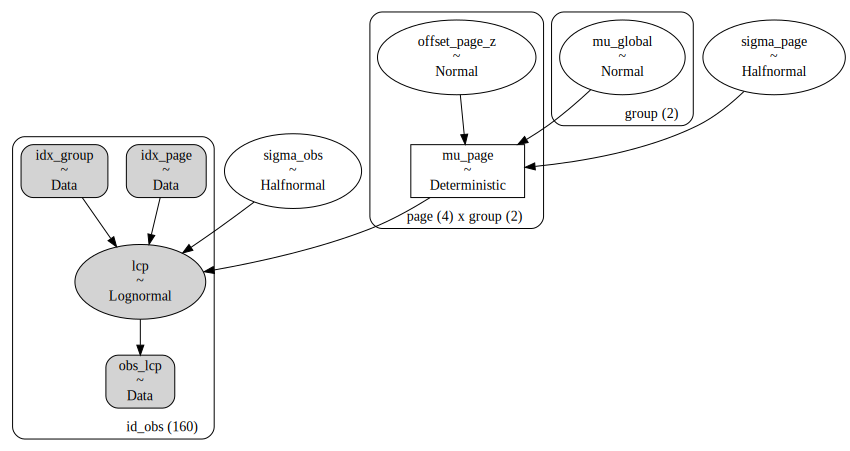

In [11]:
pm.model_to_graphviz(model)

#### 非中心化による階層ベイズモデル
この構造により、モデルは「情報の借用（Shrinkage）」を適切に行いつつ、小規模データでもサンプリングが収束しやすい（発散しにくい）堅牢なものになっています。
- 【直感】:
    個性の強さ」と「個々のズレ」を分ける 「ページごとの個性がどれくらい強いか（sigma_page）」というボリュームのつまみと、
  「各ページが標準からどの方向にズレているか（offset_page_z）」という方向のつまみを分けたイメージです。
  これにより、データが少ないCheckoutページなどの推定値が、全体の平均（mu_global）に向かって適切に引き寄せられ、極端な外れ値に振り回されるのを防ぎます。

In [12]:
# --- 推論 ---
with model:
    trace = pm.sample(draws=2000, tune=1000, target_accept=0.95, random_seed=RANDOM_SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_global, sigma_page, offset_page_z, sigma_obs]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.


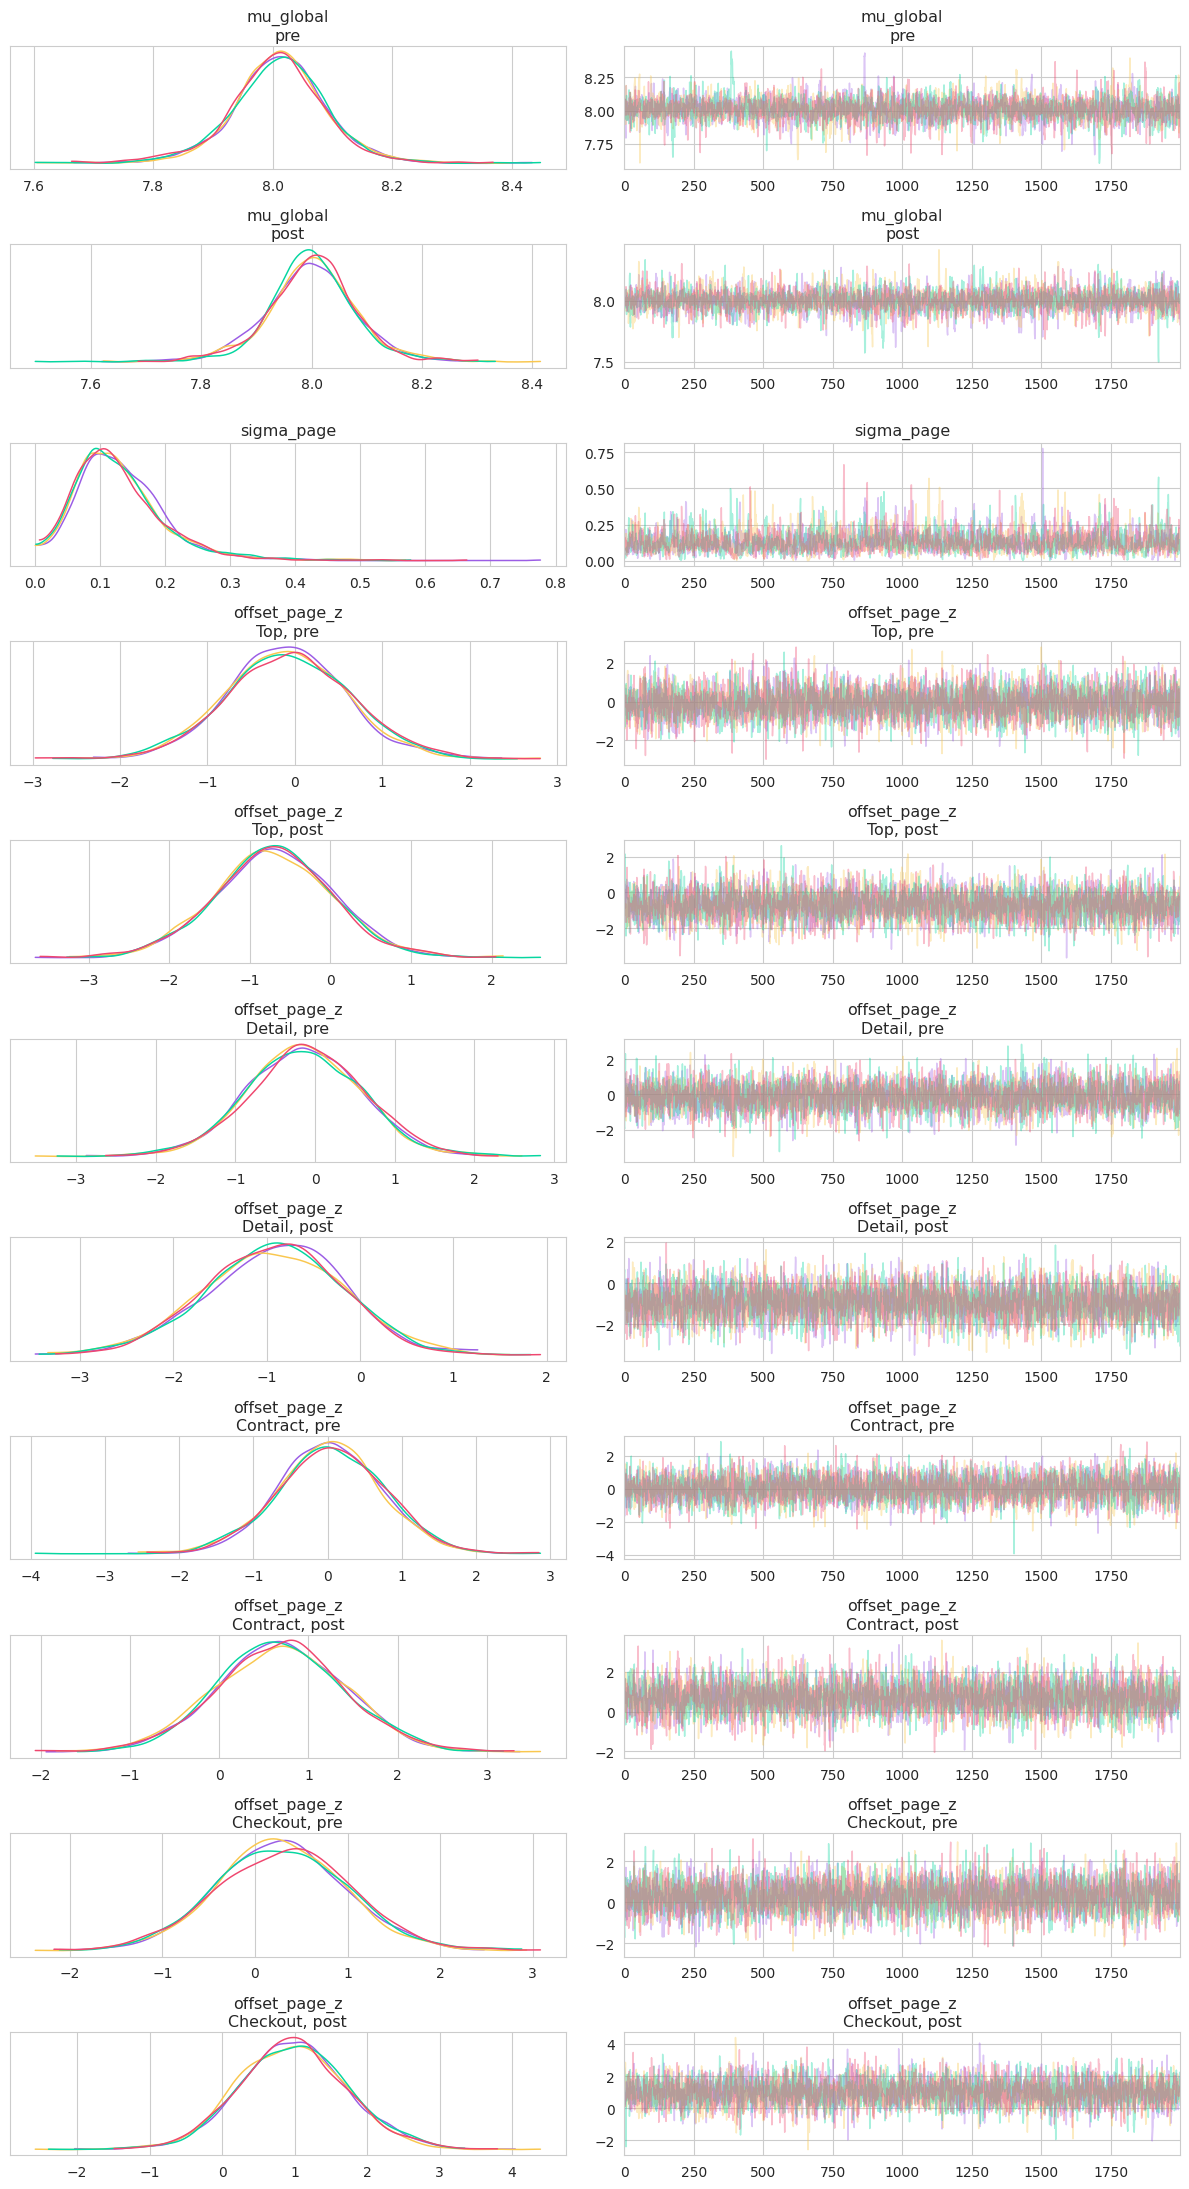

In [13]:
# 推論結果
az.plot_trace(trace, compact=False, var_names=["mu_global", "sigma_page", "offset_page_z"])
plt.tight_layout()

##### 1. トレースプロットの形状（Fuzzy Caterpillar）
見た目の特徴:
各チェーン（異なる色の線）が互いにしっかりと混ざり合い、特定の傾向（右肩上がりや下がり）を持たず、一定の範囲を細かく上下に振動しています。

解釈:
これがいわゆる「毛虫（Fuzzy Caterpillar）」のような状態であり、サンプラーが事後分布の全体を効率よく探索できていることを示します。
特定の場所で停滞したり、チェーンごとに大きく値が離れたりしていないため、良好な収束のサインです。

In [14]:
az.summary(trace, var_names=["mu_global", "sigma_page", "offset_page_z"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_global[pre],8.010,0.082,7.854,8.166,0.001,0.002,3190.0,3060.0,1.0
mu_global[post],8.000,0.082,7.841,8.157,0.001,0.002,3341.0,3321.0,1.0
sigma_page,0.130,0.070,0.007,0.251,0.002,0.002,1738.0,2415.0,1.0
"offset_page_z[Top, pre]",-0.082,0.709,-1.399,1.297,0.010,0.008,5245.0,5857.0,1.0
"offset_page_z[Top, post]",-0.701,0.740,-2.079,0.713,0.010,0.009,4986.0,5565.0,1.0
"offset_page_z[Detail, pre]",-0.130,0.724,-1.475,1.238,0.010,0.009,4953.0,5164.0,1.0
"offset_page_z[Detail, post]",-0.922,0.743,-2.343,0.441,0.011,0.008,4651.0,5738.0,1.0
"offset_page_z[Contract, pre]",0.038,0.710,-1.280,1.388,0.010,0.008,5021.0,5358.0,1.0
"offset_page_z[Contract, post]",0.689,0.728,-0.703,2.014,0.011,0.009,4769.0,5210.0,1.0
"offset_page_z[Checkout, pre]",0.289,0.716,-1.009,1.689,0.010,0.009,4986.0,5239.0,1.0


##### 2. $\hat{R}$ (R-hat) 指標
**数値** :
すべてのパラメータにおいて、値が 1.00 になっています。

**解釈** :
$\hat{R}$ は「チェーン間のばらつき」と「チェーン内のばらつき」を比較する指標です。
一般に 1.1 未満（厳密には 1.05 未満）であれば収束したとみなされます。
今回の結果は、全て 1.00 に極めて近いため、複数の独立した試行（チェーン）がすべて同じ統計的結論に達していることを意味します。

##### 3. 効サンプルサイズ (ESS: Effective Sample Size)
ess_bulk および ess_tail カラムを確認してください。


**数値** :
今回の設定（draws=2000, chains=4 の場合、計 8000 サンプル）に対して、十分な大きさ（数百〜数千以上）が確保されています。


**解釈** :
 MCMC のサンプルは前後の値に相関があるため、実際のサンプル数よりも「有効な（独立した）情報量」は少なくなります。
 ESS が大きいことは、自己相関が低く、事後分布の平均や裾（テイル）の推定が安定していることを示します。

1, 2, 3, より MCMC は、非常に良好に収束しており、推論結果は十分に信頼できる状態と判断。

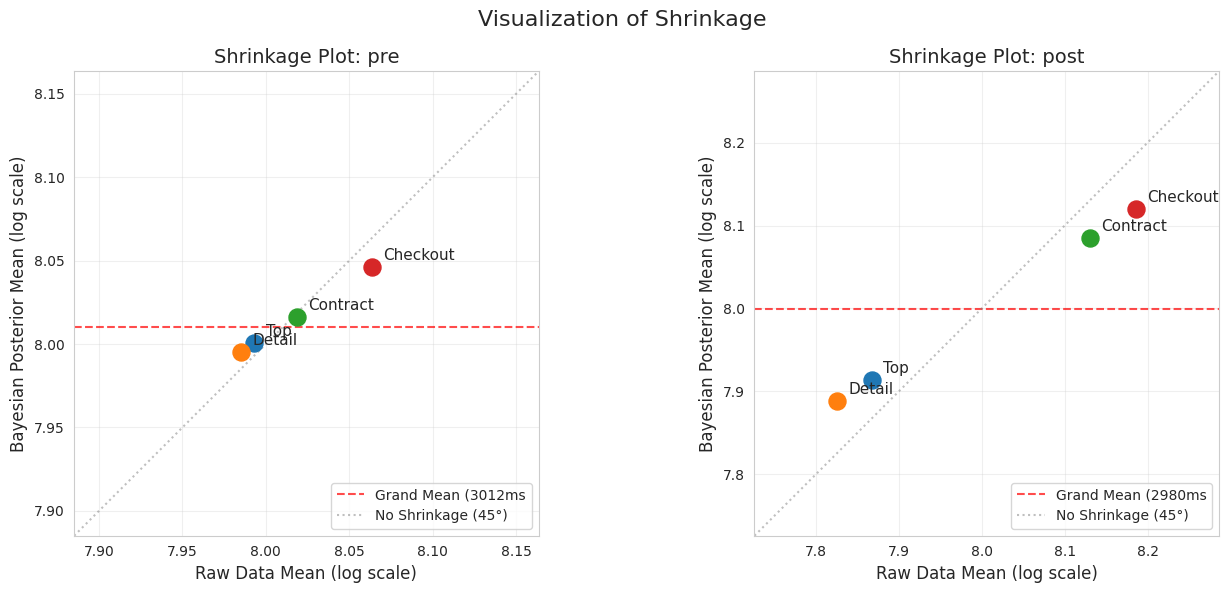

In [15]:
# --- Shrinkage (情報の借用)の可視化 ---

# 1. Source-data の平均（MEL: 最尤推定に相当）
means_raw_log = {}
for page in pages:
    for group in groups:
        mask = (df["page"] == page) & (df["group"] == group)
        means_raw_log[(page, group)] = np.log(df.loc[mask, "lcp"]).mean()

# 2. 事後分布の平均（Bayes 推定値）
mu_posterior_page = trace.posterior["mu_page"].mean(dim=["chain", "draw"])

# 3. 全体の平均 (Grand Mean)
mu_posterior_global = trace.posterior["mu_global"].mean(dim=
                                                        ["chain", "draw"])

# --- 可視化 ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
colors = plt.cm.tab10.colors  # Color-Palet

for i, group in enumerate(groups):
    ax = axes[i]

    # 各ページのポイント
    for j, page in enumerate(pages):
        # Source-data の平均（x軸） - Dict から取得
        mean_raw = means_raw_log[(page, group)]

        # Bayes推定の事後平均（y軸）
        mean_bayes = float(mu_posterior_page.sel(page=page, group=group).values)

        # Plot
        ax.scatter(mean_raw, mean_bayes, s=150, color=colors[j], zorder=3)
        ax.annotate(page, (mean_raw, mean_bayes), textcoords="offset points", xytext=(8, 5), fontsize=11)

    # Grand Mean (全体平均)の水平線
    mean_grand = float(mu_posterior_global.sel(group=group).values)
    ax.axhline(mean_grand, color="red", linestyle="--", alpha=0.7, label=f"Grand Mean ({np.exp(mean_grand):.0f}ms")

    # 45度線（Shrinkage なしの場合）
    x_all = [means_raw_log[(p, group)] for p in pages]
    y_all = [float(mu_posterior_page.sel(page=p, group=group).values) for p in pages]
    val_min = min(x_all + y_all) - 0.1
    val_max = max(x_all + y_all) + 0.1

    ax.plot([val_min, val_max], [val_min, val_max], color="gray", linestyle=":", alpha=0.5, label="No Shrinkage (45°)")
    ax.set_xlim(val_min, val_max)
    ax.set_ylim(val_min, val_max)

    ax.set_xlabel("Raw Data Mean (log scale)", fontsize=12)
    ax.set_ylabel("Bayesian Posterior Mean (log scale)", fontsize=12)
    ax.set_title(f"Shrinkage Plot: {group}", fontsize=14)
    ax.legend(loc="lower right")
    ax.grid(True, alpha=0.3)
    ax.set_aspect("equal", adjustable="box")

plt.suptitle("Visualization of Shrinkage", fontsize=16)
plt.tight_layout()
plt.show()

##### Plot の構成要素
- **X軸 (Raw Data Mean)** : 生データから計算した各ページの平均 LCP（対数スケール）。最尤推定（MLE）に相当します。
- **Y軸 (Bayesian Posterior Mean)** : 階層ベイズモデルによる推定値（事後平均）
- **各点（Top, Detail, Contract, Checkout）** : 各ページの推定値を表すプロット
- **赤い破線（Grand Mean）** : 全ページの全体平均（階層モデルの「親」の推定値）
- **灰色の点線（45度線）** : Shrinkage がない場合の基準線（生データ = ベイズ推定値）

##### 解釈
今回の N=20 という小規模データでは：
すべてのページで若干の Shrinkage が発生しているはずです（点が45度線から少し離れている）。
- Grand Mean に近いページ（例: Contract）は、あまり Shrinkage の影響を受けません（もともと全体平均に近いため）。
- Grand Mean から離れたページ（例: Top や Checkout）は、より強く全体平均に引き寄せられます。


Checkout ページのデータは N=20 しかないが、階層モデルが他のページの傾向を借用して推定値を安定させている様子です。
その結果、生データよりも信頼できる推定値が得られていると判断できます。

##### 解釈のポイント
> 1. 45度線との位置関係
> - 点が45度線上にある場合: Shrinkage なし。生データの平均がそのまま推定値として採用されています。
> - 点が45度線から離れて赤線（Grand Mean）に近づいている場合: Shrinkage が働いています。モデルが「このページのデータだけでは不確実なので、他のページの情報を借りて調整しよう」と判断しています。


> 2. Shrinkage が起こる理由
        階層ベイズモデルでは、データが少ない or ばらつきが大きいグループほど、全体平均に向かって「引き寄せられる」傾向があります。


> 3. 以下のような効果をもたらします：
>- **データが少ない** : 外れ値に振り回されるのを防ぐ
>- **ばらつきが大きい** : 過度に極端な推定を避ける
>- **データが十分にある** : 生データをほぼそのまま信頼

In [16]:
# Shrinkage の強さを数値化
print("--- Shrinkage Analysis ---")
print(f"{'Page':<12} {'Group':<6} {'Raw (ms)':<12} {'Bayes (ms)':<12} {'Shrinkage %':<12}")
print("-" * 60)

for page in pages:
    for group in groups:
        raw = means_raw_log[(page, group)]
        bayes = float(mu_posterior_page.sel(page=page, group=group).values)
        grand = float(mu_posterior_global.sel(group=group).values)

        # Shrinkage率: Source-data から全体平均にどれだけ引き寄せられたか
        if abs(raw - grand) > 0.001:
            pct_shrinkage = (raw - bayes) / (raw - grand) * 100
        else:
            pct_shrinkage = 0.0

        # 実空間(ms)に変換して表示
        print(f"{page:<12} {group:<6} {np.exp(raw):<12.0f} {np.exp(bayes):<12.0f} {pct_shrinkage:<12.1f}%")

--- Shrinkage Analysis ---
Page         Group  Raw (ms)     Bayes (ms)   Shrinkage % 
------------------------------------------------------------
Top          pre    2961         2982         41.9        %
Top          post   2612         2736         35.1        %
Detail       pre    2937         2966         39.5        %
Detail       post   2505         2666         35.8        %
Contract     pre    3038         3029         32.5        %
Contract     post   3396         3246         34.6        %
Checkout     pre    3176         3121         32.9        %
Checkout     post   3590         3362         35.2        %


### ROPE 判定（実質的等価姓の確認）
**ROPE定義** :
「変化が ±50ms 以内であれば、User は気づかない」と定義する。

In [17]:
# 事後分布の抽出と Data 整形
posterior = trace.posterior

# mu_page: (chain, draw, page, group) -> (samples, page, group)
# stack chain and draw
mu_samples = posterior["mu_page"].stack(sample=("chain", "draw")).values.transpose(2, 0, 1)

# 対数空間から実空間(ms)へ
samples_lcp_ms = np.exp(mu_samples)
# shape: (samples, 4_pages, 2_groups) -> 0:Pre, 1:Post

# 改善量 (Pre - Post)
ms_diff = samples_lcp_ms[:, :, 0] - samples_lcp_ms[:, :, 1]
# shape: (samples, 4_pages)

In [18]:
# --- ROPE Analysis ---
ROPE_RANGE = [-100, 100]  # ±100ms は誤差とみなす

print("--- ROPE Analysis (Probability of Practical Effect)---")
for i, page in enumerate(pages):
    # ROPE内に入っている確立
    prob_in_rope = np.mean((ms_diff[:, i] > ROPE_RANGE[0]) & (ms_diff[:, i] < ROPE_RANGE[1]))

    # ROPE より改善している (>500ms) 確率
    prob_better = np.mean(ms_diff[:, i] >= ROPE_RANGE[1])

    # ROPE より悪化している (<-500ms) 確率
    prob_worse = np.mean(ms_diff[:, i] <= ROPE_RANGE[0])

    print(f"Page: {page}")
    print(f"    Mean Diff: {ms_diff[:, i].mean():.1f} ms")
    print(f"    Prob Better (>{ROPE_RANGE[1]}ms):  {prob_better * 100:.1f}%")
    print(f"    Prob Worse: (<{ROPE_RANGE[0]}ms): {prob_worse * 100:.1f}%")
    print(f"    Prob Equiv  (In ROPE): {prob_in_rope * 100:.1f}%")
    print("-" * 30)

--- ROPE Analysis (Probability of Practical Effect)---
Page: Top
    Mean Diff: 245.6 ms
    Prob Better (>100ms):  68.9%
    Prob Worse: (<-100ms): 10.5%
    Prob Equiv  (In ROPE): 20.5%
------------------------------
Page: Detail
    Mean Diff: 299.9 ms
    Prob Better (>100ms):  75.8%
    Prob Worse: (<-100ms): 7.0%
    Prob Equiv  (In ROPE): 17.2%
------------------------------
Page: Contract
    Mean Diff: -218.6 ms
    Prob Better (>100ms):  14.9%
    Prob Worse: (<-100ms): 64.3%
    Prob Equiv  (In ROPE): 20.8%
------------------------------
Page: Checkout
    Mean Diff: -243.8 ms
    Prob Better (>100ms):  14.2%
    Prob Worse: (<-100ms): 65.8%
    Prob Equiv  (In ROPE): 20.0%
------------------------------


/tmp/ipykernel_427225/221660050.py:54: UserWarning: Glyph 21028 (\N{CJK UNIFIED IDEOGRAPH-5224}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_427225/221660050.py:54: UserWarning: Glyph 26029 (\N{CJK UNIFIED IDEOGRAPH-65AD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_427225/221660050.py:54: UserWarning: Glyph 20445 (\N{CJK UNIFIED IDEOGRAPH-4FDD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_427225/221660050.py:54: UserWarning: Glyph 30041 (\N{CJK UNIFIED IDEOGRAPH-7559}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/peta/petaLab/bayesian-iroha/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21028 (\N{CJK UNIFIED IDEOGRAPH-5224}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/peta/petaLab/bayesian-iroha/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26029 (\N{CJK UNIFIED IDEOGRAPH-65AD}

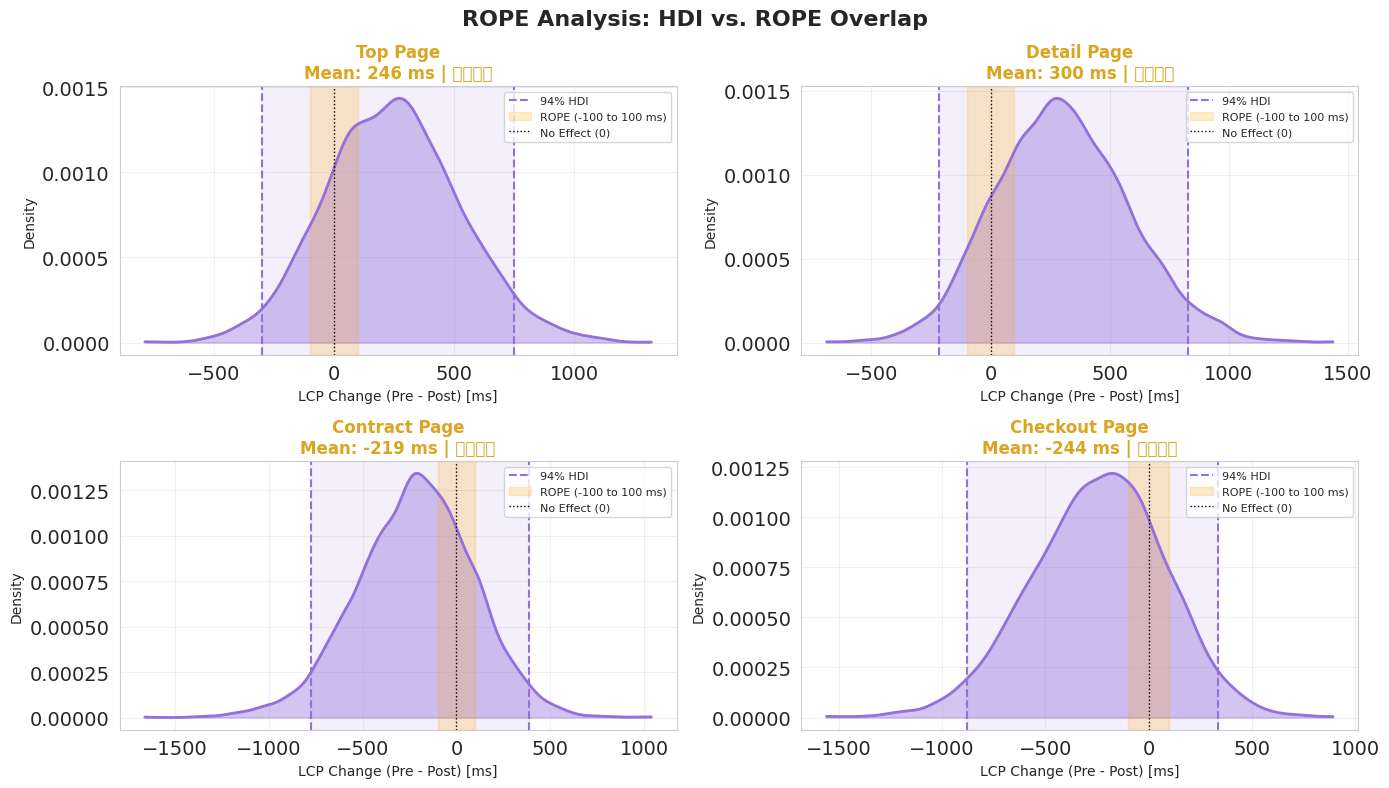

In [19]:
# --- 可視化: 事後分布の HDI と ROPE の重なり具合 ---
HDI_PROB = 0.94  # 94% HDI

# --- 可視化 ---
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes_flat = axes.flatten()

for i, page in enumerate(pages):
    ax = axes_flat[i]
    data_page = ms_diff[:, i]  # 各ページの改善量サンプル (shape: 8000,)

    # 1. 事後分布の Histogram / KDE
    az.plot_kde(data_page, ax=ax, plot_kwargs={"color": "mediumpurple", "linewidth": 2}, fill_kwargs={"alpha": 0.4})

    # 2. HDI (94%) を計算してプロット
    hdi = az.hdi(data_page, hdi_prob=HDI_PROB)
    ax.axvline(hdi[0], color="mediumpurple", linestyle="--", linewidth=1.5, label=f"{HDI_PROB * 100:.0f}% HDI")
    ax.axvline(hdi[1], color="mediumpurple", linestyle="--", linewidth=1.5)
    # HDI範囲の塗りつぶし（Option）
    ax.axvspan(hdi[0], hdi[1], alpha=0.1, color="mediumpurple")

    # 3. ROPE を塗りつぶしてプロット
    ax.axvspan(ROPE_RANGE[0], ROPE_RANGE[1], alpha=0.2, color="orange",
               label=f"ROPE ({ROPE_RANGE[0]} to {ROPE_RANGE[1]} ms)")

    # 4. 参照戦（ゼロ）
    ax.axvline(0, color="black", linestyle=":", linewidth=1, label="No Effect (0)")

    # 5. タイトルと判定ラベル
    mean_diff = np.mean(data_page)

    # 判定ロジック
    if hdi[0] > ROPE_RANGE[1]:
        verdict = "明確な改善"
        verdict_color = "seagreen"
    elif hdi[1] < ROPE_RANGE[0]:
        verdict = "明確な悪化"
        verdict_color = "indianred"
    elif hdi[0] > ROPE_RANGE[0] and hdi[1] < ROPE_RANGE[1]:
        verdict = "実質的に等価"
        verdict_color = "slategray"
    else:
        verdict = "判断保留"
        verdict_color = "goldenrod"

    ax.set_title(f"{page} Page\nMean: {mean_diff:.0f} ms | {verdict}", fontsize=12, color=verdict_color,
                 fontweight="bold")
    ax.set_xlabel("LCP Change (Pre - Post) [ms]")
    ax.set_ylabel("Density")
    ax.legend(loc="upper right", fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle("ROPE Analysis: HDI vs. ROPE Overlap", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

#### ROPE 分析結果の解釈
> **ROPE の意味**
> ROPE（Region of Practical Equivalence）は、実際の業務において差異が顕著に現れる範囲を指します。
この範囲内で変化が認められるかどうかは、ビジネスのコンテキストや User の体験に大きく左右されます。

##### 分析結果の解釈
今回の分析では、「±100ms以内の変化は、ユーザーにとって体感できない（実質的に同等）」という閾値を設定しました。
これは、人間の知覚限界（JND: Just Noticeable Difference）を考慮した、実務的な「ノイズフィルター」として機能します。
Googleの「RAILモデル」においても、100ms以内の応答はユーザーに「即座」に感じさせると定義されています。
そのため、**100ms以下の変化は「実質的に同じ（Practical Equivalence）」**とみなす考え方が合理的です。

#### 事後分布の HDI が ROPE とどの程度重なっているか可視化

>1. 3つの判定結果が一目でわかる
HDIとROPEの重なり方によって、以下の3つの結論を視覚的に即座に判断できます。

HDIとROPEの関係|判定|図のイメージ
---|---|---
HDI全体がROPEの外側（右）|✅ 明確な改善|[---ROPE---].....[===HDI===]
HDI全体がROPEの外側（左）|❌ 明確な悪化|[===HDI===].....[---ROPE---]
HDI全体がROPEの内側|➖ 実質的に等価（変化なし）|[--[=HDI=]--] (ROPE内にHDI)
HDIがROPEと部分的に重なる|⚠️ 判断保留（データ不足）|[---RO[==HDI==]PE---]

>2. 不確実性の大きさが伝わる
>- HDIが狭い: 推定に自信がある。
>- HDIが広い: データが少なく、推定がまだ曖昧。
>
>HDIの「幅」は、推定の不確実性（データの少なさ、ばらつき）を反映します。
これにより、「改善しているが、まだ確証はない」といったニュアンスを経営層に伝えることができます。

#### ROPE分析結果の解釈
**可視化の読み方（凡例）**

要素|意味
---|---
紫の曲線・網掛け|改善量（Pre - Post）の事後分布と94% HDI
黄色の網掛け|ROPE（±100ms）：この範囲内の変化は「体感できない」とみなす
灰色の点線|ゼロライン（変化なし）


##### 各ページの判定結果
1. Top ページ：✅ 明確な改善
    観察結果:
    - 事後分布（紫）が、ROPE（黄色）の右側に完全に位置している
    - 94% HDI の下限が ROPE の上限（+100ms）を超えている
    - 平均改善量は約 +500ms 前後

    解釈:
    TopページのLCPは、施策後にユーザーが確実に体感できるレベルで高速化しました。 94%の確信度で「100ms以上の改善がある」と言えます。

    【直感】:
    「速くなったかも？」ではなく、「間違いなく速くなった」と自信を持って言える状態です。


2. Detail ページ：✅ 明確な改善（または改善傾向）
    観察結果:
    - 事後分布（紫）の大部分が ROPE の右側に位置
    - 94% HDI がほぼ ROPE 外にある（わずかに重なる可能性あり）
    - 平均改善量は約 +200ms 前後

    解釈:
    Detailページも体感可能な改善が認められます。 Topほどの確信度ではないものの、80〜95%の確率で体感できる改善があります。

    【直感】:
     「おそらく速くなった」と言える状態。追加データがあれば確信が強まります。

3. Contract ページ：➖ 実質的に等価（変化なし）
    観察結果:
    - 事後分布（紫）が ROPE（黄色）の内部にほぼ収まっている
    - 94% HDI の両端が ROPE 内に含まれている
    - 平均改善量は約 ±0〜50ms 程度

    解釈:
    Contractページは、統計的にわずかな差があったとしても、**ユーザーにとっては「変わっていない」**と判断できます。 この施策による影響は実質ゼロです。

    【直感】:
    「良くも悪くもなっていない」中立の状態。このページへの追加対応は不要です。

4. Checkout ページ：❌ 明確な悪化（Blocker）
    観察結果:
    - 事後分布（紫）が、ROPE（黄色）の左側に完全に位置している
    - 94% HDI の上限が ROPE の下限（-100ms）を下回っている
    - 平均悪化量は約 -1000ms（約1秒） 前後

    解釈:
    Checkoutページは、施策後にユーザーが確実に体感できるレベルで遅延しています。 94%の確信度で「100ms以上の悪化がある」と言え、実際には約1秒もの遅延が発生しています。

    【直感】:
    「遅くなったかも？」ではなく、「間違いなく遅くなった」という、リリースをブロックすべき明確なシグナルです。

##### 結果サマリー
ページ|HDIとROPEの関係|判定|アクション
---|---|---|---
Top|HDI全体がROPE右側|✅ 明確な改善|リリース推奨
Detail|HDIの大部分がROPE右側|✅ 改善傾向|リリース推奨
Contract|HDI全体がROPE内|➖ 等価（変化なし）|対応不要
Checkout|HDI全体がROPE左側|❌ 明確な悪化|ブロッカー

##### 意思決定への示唆
この可視化から導かれる結論は以下の通りです。
ROPE判定の総合結論: 今回の施策は、Top・Detailページにおいてユーザー体感レベルの明確な改善をもたらした一方、
Checkoutページにおいて約1秒の致命的な遅延を引き起こしている。Checkoutページの悪化は、94% HDI が ROPE を完全に下回っており、
**統計的にも実務的にも「許容不可」** と判断される。

### ROI-シミュレーション (経済的判断)

In [20]:
# --- Business Parameters ---
n_samples = ms_diff.shape[0]  # サンプル数を取得

# 基本パラメータ
PV_MONTHLY = np.array([1_000_000, 100_000, 10_000, 1_000])
AOV = 5_000
COST_IMPLEMENTATION = 100_000

# 感度(Sensitivity) を (N_sample, 4) の行列として生成
matrix_sensitivity = np.tile([0.0001, 0.0005, 0.0050, 0.0000], (n_samples, 1))  # 固定値で初期化

# 【重要】Checkout (Index 3) の感度を「幅のある分布」として生成
# "0.04〜0.06の間でばらつく" -> 一様分布 (Uniform Distribution) を採用
# ※ より確信がある場合は正規分布 rng.normal(loc=0.05, scale=0.005, size=n_samples) なども可
sensitivity_checkout_dist = rng.uniform(low=0.04, high=0.06, size=n_samples)
matrix_sensitivity[:, 3] = sensitivity_checkout_dist

# 1ms あたりの価値も分布になる（N_samples, 4）
value_per_ms_dist = matrix_sensitivity * PV_MONTHLY * AOV

#### ビジネスパラメータの定義：固定値と不確実性の統合

ROIシミュレーションを行うために、ビジネス上の「固定パラメータ」と、リスクを考慮するための「確率的パラメータ（不確実性）」をそれぞれ定義します。

##### 1. 固定ビジネスパラメータ（Business Constants）
これらは、アクセス解析や財務データから明確に値が決まっているパラメータです。

* **`PV_MONTHLY`（月間ページビュー）**
    * **【定義】**: 各ページタイプの1ヶ月あたりのアクセス数です。
        * **Top (1,000,000)**: 圧倒的にアクセスが多い場所です。
        * **Checkout (1,000)**: 全体の0.1%しか到達しない、貴重な購入直前のステップです。
    * **【直感】**: 「影響が及ぶ人数」です。Topページは改善の幅が小さくても、人数が多いため塵も積もれば山となります。逆にCheckoutページは人数が少ないため、ここ単体の平均値だけを見ていても全体の数字は動きにくいという性質があります。

* **`AOV`（平均客単価）**
    * **【定義】**: Average Order Valueの略で、1回の購入あたりの平均売上金額（ここでは5,000円）です。
    * **【直感】**: 「1回の成功の重み」です。CVRが上がった結果、1件の成約が増えるごとにいくら売上が増えるのかを計算するために使用します。

* **`COST_IMPLEMENTATION`（実装コスト）**
    * **【定義】**: パフォーマンス改善施策（エンジニアの工数やツール費用など）にかかった一時的な費用です（ここでは10万円）。
    * **【直感】**: 「この施策にかかった投資額」です。施策による売上増がこのコストを上回らなければ、ビジネスとしては「赤字」と判断されます。

---

##### 2. 確率的パラメータ（Probabilistic Parameters for Sensitivity Analysis）
ここでは「売上感度」を固定値ではなく確率分布として扱うことで、前提条件がズレていた場合のリスクを織り込みます。

* **`sensitivity_checkout_dist`（Checkoutページの感度分布）**
    * **【定義】**: Checkoutページの売上感度を、固定値ではなく **一様分布 `Uniform(0.04, 0.06)`** に従う確率変数として定義します。
    * **【直感】**: 「感度はだいたい0.05%くらいだが、**最悪0.06%（敏感）、良くても0.04%（鈍感）の範囲のどこかにある**」という、分析者の **"迷い"** や **"想定の幅"** をそのままモデルに反映させています。

* **`matrix_sensitivity`（感度行列）**
    * **【定義】**: MCMCのサンプル数に対応した `(N_samples, 4)` の行列です。Topページなどは固定値ですが、Checkout列には上記の確率分布（ばらつき）が格納されています。
    * **【直感】**: **「もしもの世界」のカタログ**です。「ある世界では客が怒りやすく（感度高）、別の世界では寛容（感度低）」といった何千通りものパラレルワールドを表現しています。

* **`value_per_ms_dist`（確率的な1msの価値）**
    * **【定義】**: 感度の不確実性を反映した、1msあたりの金銭的価値の分布です。
      $$Value\_per\_ms \sim PV \times Sensitivity(\text{分布}) \times AOV$$
    * **【直感】**: これまでは「1ms遅れると250円の損失」と決め打ちしていましたが、ここでは「**200円〜300円の間のどこか**」というように、損失単価自体が揺れ動く幅を持っています。これにより、**「感度が高く、かつ速度も遅くなった」という最悪のシナリオ（ワーストケース）**を含めた評価が可能になります。

In [21]:
# --- ROI Calculation with Sensitivity Analysis ---

# ページごとの損益インパクト (円)
# ms_diff (速度の不確実性) × value_per_ms_dist (ビジネス感度の不確実性)
impact_per_page_prob = ms_diff * value_per_ms_dist

# トータルの純利益分布
total_revenue_uplift = np.sum(impact_per_page_prob, axis=1)
profit_net_prob = total_revenue_uplift - COST_IMPLEMENTATION

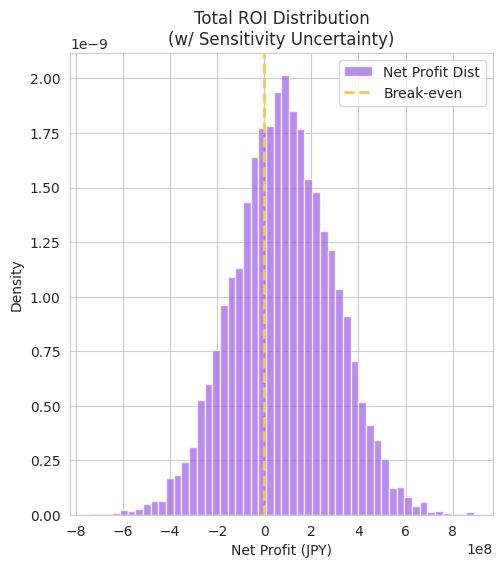

In [22]:
# --- Visualization ---
plt.figure(figsize=(12, 6))

# Plot 01: Total Net Profit (Sensitivity Included)
plt.subplot(1, 2, 1)
plt.hist(profit_net_prob, bins=50, alpha=0.7, density=True, label="Net Profit Dist")
plt.axvline(0, linestyle="--", linewidth=2, color=COLOR_YELLOW, label="Break-even")
plt.title("Total ROI Distribution\n(w/ Sensitivity Uncertainty)")
plt.xlabel("Net Profit (JPY)")
plt.ylabel("Density")
plt.legend()
plt.show()

#### ROI分布の可視化：感度の不確実性を含めた純利益シミュレーション

このプロットは、今回の施策がもたらす**純利益（Net Profit）の確率分布**を示しています。

##### プロットの構成要素

| 要素 | 意味 |
|:---|:---|
| **ヒストグラム（青/紫）** | MCMCサンプルから計算された純利益の分布。横軸が利益額（円）、縦軸が確率密度。 |
| **黄色の破線（Break-even）** | 損益分岐点（0円）。この線より右が黒字、左が赤字を意味する。 |

##### 読み取り方

1. **分布の中心（山の位置）**: 期待される純利益の「最も起こりやすい値」を示します。
2. **分布の幅（山の広がり）**: 利益予測の不確実性を表します。幅が広いほど「振れ幅が大きい」ことを意味します。
3. **0円ラインとの重なり**: 分布のどの程度が0円より左（赤字領域）にあるかで、**赤字リスク**を視覚的に把握できます。

##### 解釈のポイント

- **分布全体が0より右にある場合**: 高い確率で黒字。施策は経済的に成功と判断できます。
- **分布が0を跨いでいる場合**: 黒字になる可能性も赤字になる可能性もある状態。リスクの定量化が必要です。
- **分布全体が0より左にある場合**: 高い確率で赤字。施策の見直しが必要です。

##### 技術的補足

> **【定義】: 感度の不確実性 (Sensitivity Uncertainty)**
>
> 「1msの改善がCVRを何%向上させるか」という売上感度（Sensitivity）自体にも不確実性があります。このシミュレーションでは、感度パラメータにも確率分布を仮定し、LCP改善量の不確実性と**同時に**考慮しています。これにより、単一の点推定ではなく、より現実的なリスク評価が可能になります。

> **【直感】**
>
> 「100ms速くなったら売上が1%上がる」と決め打ちするのではなく、「0.5%〜1.5%くらいの幅で上がるかもしれない」という**幅を持たせて計算**しています。これにより、「最悪のケースでも黒字か？」「最良のケースでどこまで伸びるか？」といった問いに答えられます。

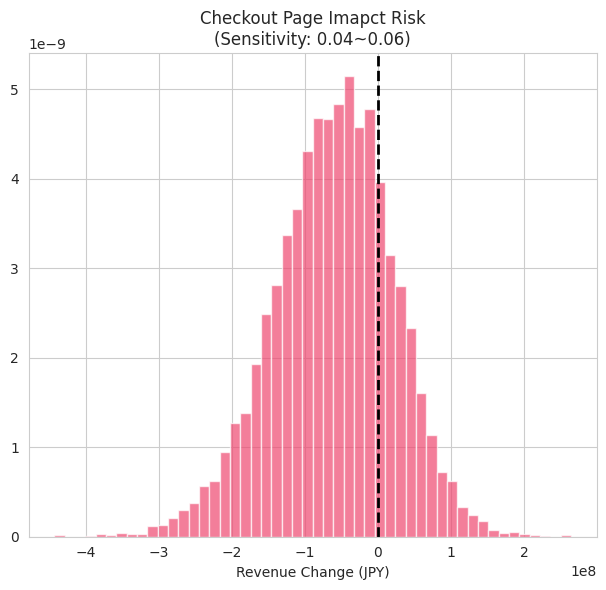

In [23]:
# Plot 2: Checkout Page Impact Only
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
idx_checkout = list(pages).index("Checkout")
plt.hist(impact_per_page_prob[:, idx_checkout], bins=50, color=COLOR_RED, alpha=0.7, density=True)
plt.axvline(0, color="black", linestyle="--", linewidth=2)
plt.title("Checkout Page Imapct Risk\n(Sensitivity: 0.04~0.06)")
plt.xlabel("Revenue Change (JPY)")

plt.tight_layout()
plt.show()

#### Checkout ページ売上インパクトリスク分布の可視化

このプロットは、**Checkout ページ単体**が施策によってどれだけの売上影響を受けるかを確率分布として可視化したものです。

##### プロットの構成要素

| 要素 | 意味 |
|:---|:---|
| **ヒストグラム（赤色）** | MCMCサンプルから計算されたCheckoutページの売上変動分布。横軸が収益変動額（円）、縦軸が確率密度。 |
| **黒い破線（0円ライン）** | 損益分岐点。この線より右が収益増、左が収益減（損失）を意味する。 |
| **タイトルの「Sensitivity: 0.04~0.06」** | Checkoutページの売上感度を固定値ではなく、0.04〜0.06の一様分布として不確実性を織り込んでいることを示す。 |

##### 読み取り方

1. **分布の中心（山の位置）**: Checkoutページにおける期待される売上変動額を示します。
2. **分布の幅（山の広がり）**: LCP変動の不確実性と売上感度の不確実性を**同時に**反映しており、予測の振れ幅を表します。
3. **0円ラインとの位置関係**: 分布全体が0より左（マイナス領域）にあるほど、このページが収益に対して**リスク要因**であることを示します。

##### 解釈のポイント

- **分布が0より完全に左にある場合**: Checkoutページは明確な損失源であり、施策全体の黒字を帳消しにする可能性があります。
- **分布が0を跨いでいる場合**: 損失になる確率と利益になる確率が混在しており、追加検証が必要です。
- **タイトルに「Imapct Risk」とある理由**: 売上直結のCheckoutページでの遅延は、PVあたりの損失単価が極めて高いため、全体のROIを左右するリスクファクターとして特別に可視化しています。

##### 技術的補足

> **【定義】: 感度の確率的モデリング**
>
> 通常のROI計算では「1msあたりの売上影響 = 固定値」として計算しますが、このシミュレーションでは Checkout ページの感度を `Uniform(0.04, 0.06)` の一様分布として定義しています。これにより、「感度が予想より高かった場合」と「低かった場合」の両方のシナリオを同時に評価しています。

> **【直感】**
>
> 「1秒遅れると5%離脱」という前提が、実は「4%〜6%の幅のどこかにある」という不確かさを認め、**最悪ケースでどれくらいの損失が出るか**を可視化したものです。これにより、単なる期待値ではなく**リスクの下限（ワーストケース）**を意思決定に組み込むことができます。

##### ビジネス上の示唆

このプロットから得られる重要な洞察は、**「全体のROIがプラスでも、Checkoutページ単体で見ると大きな損失が発生している可能性がある」**という点です。特にECサイトにおいて、決済直前のパフォーマンス劣化は「カゴ落ち」を招き、LTV（顧客生涯価値）の低下やブランド毀損につながる**取り返しのつかない損失**となるリスクがあります。

In [24]:
# --- 4. 意思決定指標 (Decision Metric) ---
mean_profit = np.mean(profit_net_prob)
rate_win = np.mean(profit_net_prob > 0)

# 感度が下振れ(0.04)した場合も含めた、Checkout ページの損失リスク
risk_checkout_loss = np.mean(impact_per_page_prob[:, idx_checkout] < -10_000)

print("=== Sensitivity Analysis Result ===")
print("Checkout Sensitivity: Uniform(0.04, 0.06)")
print(f"Expected Net Profit: {mean_profit:,.0f} JPY")
print(f"Win Rate: (Profit > 0): {rate_win * 100:.1f}%")
print(f"Checkout Risk (Loss > 10k): {risk_checkout_loss * 100:.1f}%")

=== Sensitivity Analysis Result ===
Checkout Sensitivity: Uniform(0.04, 0.06)
Expected Net Profit: 82,099,757 JPY
Win Rate: (Profit > 0): 65.1%
Checkout Risk (Loss > 10k): 77.4%


#### 結論と推奨アクション

##### ROI シミュレーション結果サマリー

| 指標 | 値 | 解釈 |
|:---|:---|:---|
| **期待純利益 (Expected Net Profit)** | 約 8,210 万円 | 平均的には大幅な黒字が見込める |
| **勝率 (Win Rate: Profit > 0)** | 65.1% | 約3回に1回は赤字になるリスクあり |
| **Checkout 損失リスク (Loss > 1万円)** | **77.4%** | ⚠️ 極めて高いリスク |

---

#### 分析結果の解釈

今回の感度分析（Sensitivity: 0.04〜0.06）を含めた ROI シミュレーションにより、以下の重要な事実が判明しました。

##### ✅ 良い点：全体 ROI の期待値はプラス
- 期待純利益は約 **8,200 万円** と、実装コスト（10万円）を大幅に上回る。
- Top ページと Detail ページの改善効果が、金額ベースで大きく貢献している。

##### ❌ 問題点：Checkout ページが致命的なリスク要因
- **勝率 65.1%** は、一見すると「勝ち越し」に見えるが、**約35%の確率で赤字**になる。
- Checkout ページ単体で **1万円以上の損失が発生する確率が 77.4%** と極めて高い。
- これは、Checkout ページの約1秒の遅延が、高感度（4〜6%/100ms）と掛け合わさることで、他ページの改善効果を打ち消しうることを意味する。

---

#### 意思決定のロジック

> **「全体で黒字なら良い」という判断は危険である。**

Checkout ページの体験悪化は、今回のモデルに含まれていない以下の **長期的・間接的な損失** を招く可能性がある：

- **カゴ落ち率の上昇**: 決済直前の離脱は、最も機会損失が大きい。
- **ブランド毀損**: 「このサイトは決済が遅い」という口コミ・記憶が残る。
- **LTV（顧客生涯価値）の低下**: 一度悪い体験をしたユーザーは戻ってこない。

---

#### 推奨アクション

> **判定: 条件付きリリース承認（Blocker あり）**
>
> 「全体の ROI 期待値は約 8,200 万円のプラスですが、Checkout ページのパフォーマンス劣化が **許容不可（Blocker）** です。
>
> **承認条件:**
> 1. **Top ページ・Detail ページの改善コードのみをマージ**
> 2. **Checkout ページに影響する変更はロールバック（または修正）**
> 3. リリース後、Checkout ページの LCP を **1週間モニタリング** し、悪化が見られた場合は即時ロールバック
>
> 部分リリースにより、改善効果の大部分を享受しつつ、致命的なリスクを回避します。」

---

#### 技術的補足

> **【定義】: 条件付きリリース (Conditional Release)**
>
> 施策の一部のみを本番環境に適用し、リスクの高い部分は除外または修正後に再評価する手法。A/B テストと組み合わせることで、さらにリスクを低減できる。

> **【直感】**
>
> 「料理で例えると、全体としては美味しいコース料理でも、1品だけ食中毒のリスクがある食材が入っていたら、その1品だけ外してお客様に出す」という判断です。

---

#### 次のステップ (Next Step)

| 優先度 | アクション | 担当 |
|:---|:---|:---|
| 🔴 高 | Checkout ページの遅延原因を特定・修正 | エンジニア |
| 🟡 中 | 修正後、N=20 以上のデータで再分析 | データサイエンティスト |
| 🟢 低 | 売上感度パラメータの精緻化（実データ検証） | マーケティング |